# 👥 Member Segmentation & Behavioral Analysis

## 🎯 **Advanced Customer Segmentation for Targeted Strategies**

Using unsupervised machine learning to identify distinct member groups and develop targeted engagement strategies:

### 🔍 **Segmentation Approaches**

#### **1. Behavioral Segmentation**
- **Reading Frequency**: Heavy users, moderate readers, occasional borrowers
- **Genre Preferences**: Fiction lovers, academic researchers, children's book readers
- **Engagement Patterns**: Digital natives, traditional readers, mixed-media users

#### **2. Demographic Segmentation**
- **Life Stage**: Students, working professionals, retirees, families
- **Geographic**: Branch preferences, commuting patterns, local community ties
- **Membership Tier**: Bronze, Silver, Gold engagement levels

#### **3. Risk-Based Segmentation**
- **Churn Risk**: High, medium, low probability of leaving
- **Late Return Patterns**: Chronic late returners, occasional issues, punctual members
- **Penalty Behavior**: Quick payers, delayed payments, chronic non-payers

### 📊 **Clustering Techniques**
- **K-Means**: Traditional centroid-based clustering
- **Hierarchical Clustering**: Dendrograms for optimal cluster selection
- **DBSCAN**: Density-based clustering for outlier detection
- **Gaussian Mixture Models**: Probabilistic cluster membership

### 🎯 **Business Applications**
- **Targeted Marketing**: Personalized campaigns for each segment
- **Resource Allocation**: Staff and inventory optimization by segment
- **Retention Strategies**: Proactive interventions for at-risk segments
- **Collection Development**: Acquisition strategies aligned with segment preferences

In [1]:
# Member Segmentation Setup
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Clustering Libraries
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import scipy.cluster.hierarchy as sch

print("👥 Member Segmentation environment ready!")
print("🔍 Clustering algorithms and visualization tools loaded")
print("📊 Ready for advanced behavioral analysis")

👥 Member Segmentation environment ready!
🔍 Clustering algorithms and visualization tools loaded
📊 Ready for advanced behavioral analysis


## 📊 **Data Loading & Feature Engineering**

### Building comprehensive member profiles for segmentation analysis

In [9]:
# 📊 COMPREHENSIVE MEMBER FEATURE EXTRACTION
print("📊 **BUILDING MEMBER PROFILES FOR SEGMENTATION**")
print("=" * 60)

# Connect to database
conn = sqlite3.connect('library.db')

# Comprehensive member behavioral data
member_features_query = """
SELECT 
    m.Member_ID,
    m.Member_Type,
    
    -- Reading Volume & Frequency
    COUNT(DISTINCT l.Loan_ID) as Total_Loans,
    COUNT(DISTINCT l.Item_ID) as Unique_Books_Read,
    COUNT(DISTINCT i.Category_ID) as Genre_Diversity,
    COUNT(DISTINCT i.Author_ID) as Author_Diversity,
    
    -- Temporal Behavior
    julianday('now') - MIN(julianday(l.Issue_Date)) as Days_As_Member,
    julianday('now') - MAX(julianday(l.Issue_Date)) as Days_Since_Last_Loan,
    
    -- Return Behavior
    COUNT(CASE WHEN l.Status = 'Returned' AND l.Return_Date <= l.Due_Date THEN 1 END) as On_Time_Returns,
    COUNT(CASE WHEN l.Status = 'Returned_Late' THEN 1 END) as Late_Returns,
    COUNT(CASE WHEN l.Status = 'Overdue' THEN 1 END) as Current_Overdue,
    
    -- Engagement Quality
    AVG(CASE 
        WHEN l.Return_Date IS NOT NULL THEN julianday(l.Return_Date) - julianday(l.Issue_Date)
        ELSE julianday('now') - julianday(l.Issue_Date)
    END) as Avg_Days_Kept,
    
    -- Recent Activity (last 6 months)
    COUNT(CASE WHEN l.Issue_Date >= date('now', '-6 months') THEN 1 END) as Recent_Loans,
    
    -- Book Preferences
    AVG(i.Year) as Avg_Publication_Year,
    AVG(i.Pages) as Avg_Book_Length

FROM Member m
LEFT JOIN Loan l ON m.Member_ID = l.Member_ID
LEFT JOIN Item i ON l.Item_ID = i.Item_ID
GROUP BY m.Member_ID, m.Member_Type
"""

# Load member features
member_data = pd.read_sql_query(member_features_query, conn)

# Get additional category preferences
category_preferences_query = """
SELECT 
    l.Member_ID,
    i.Category_ID,
    COUNT(*) as Category_Loans,
    AVG(CASE 
        WHEN l.Status = 'Returned' AND l.Return_Date <= l.Due_Date THEN 5.0
        WHEN l.Status = 'Returned_Late' THEN 3.0  
        WHEN l.Status = 'Overdue' THEN 2.0
        ELSE 4.0 
    END) as Category_Satisfaction
FROM Loan l
JOIN Item i ON l.Item_ID = i.Item_ID
GROUP BY l.Member_ID, i.Category_ID
"""

category_prefs = pd.read_sql_query(category_preferences_query, conn)
conn.close()

print(f"📚 Loaded data for {len(member_data)} members")
print(f"🏷️  Category preferences: {len(category_prefs)} member-category combinations")

# Feature Engineering
print(f"\n🔧 **ADVANCED FEATURE ENGINEERING**")

# Handle missing values
member_data = member_data.fillna(0)

# Calculate derived features
member_data['Loans_Per_Day'] = member_data['Total_Loans'] / np.maximum(member_data['Days_As_Member'], 1)
member_data['Late_Return_Rate'] = member_data['Late_Returns'] / np.maximum(member_data['Total_Loans'], 1)
member_data['Recent_Activity_Rate'] = member_data['Recent_Loans'] / np.maximum(member_data['Total_Loans'], 1)
member_data['Book_Completion_Rate'] = member_data['On_Time_Returns'] / np.maximum(member_data['Total_Loans'], 1)

# Engagement scores
member_data['Reading_Intensity'] = np.log1p(member_data['Total_Loans']) * member_data['Genre_Diversity']
member_data['Exploration_Score'] = member_data['Author_Diversity'] / np.maximum(member_data['Unique_Books_Read'], 1)
member_data['Loyalty_Score'] = np.log1p(member_data['Days_As_Member']) * member_data['Recent_Activity_Rate']

# Risk indicators
member_data['Churn_Risk_Score'] = (
    (member_data['Days_Since_Last_Loan'] > 180).astype(int) * 0.4 +
    (member_data['Recent_Activity_Rate'] < 0.2).astype(int) * 0.3 +
    (member_data['Late_Return_Rate'] > 0.3).astype(int) * 0.3
)

# Member lifecycle stage
def get_lifecycle_stage(row):
    if row['Days_As_Member'] < 30:
        return 'New'
    elif row['Days_As_Member'] < 365:
        return 'Growing'
    elif row['Recent_Activity_Rate'] > 0.5:
        return 'Active'
    elif row['Recent_Activity_Rate'] > 0.1:
        return 'Declining'
    else:
        return 'Inactive'

member_data['Lifecycle_Stage'] = member_data.apply(get_lifecycle_stage, axis=1)

# Value segmentation
member_data['Member_Value'] = (
    member_data['Total_Loans'] * 0.3 +
    member_data['Genre_Diversity'] * 0.2 +
    member_data['Recent_Loans'] * 0.3 +
    member_data['Book_Completion_Rate'] * 0.2
)

# Create category preference profiles
print(f"\n🏷️  **BUILDING CATEGORY PREFERENCE PROFILES**")

# Get top categories for each member
member_top_categories = category_prefs.loc[category_prefs.groupby('Member_ID')['Category_Loans'].idxmax()]
member_data = member_data.merge(
    member_top_categories[['Member_ID', 'Category_ID']].rename(columns={'Category_ID': 'Preferred_Category'}),
    on='Member_ID',
    how='left'
)

# Calculate category diversity
category_diversity = category_prefs.groupby('Member_ID').agg({
    'Category_ID': 'nunique',
    'Category_Satisfaction': 'mean'
}).rename(columns={'Category_ID': 'Category_Diversity_Detailed', 'Category_Satisfaction': 'Avg_Category_Satisfaction'})

member_data = member_data.merge(category_diversity, left_on='Member_ID', right_index=True, how='left')
member_data['Category_Diversity_Detailed'] = member_data['Category_Diversity_Detailed'].fillna(0)
member_data['Avg_Category_Satisfaction'] = member_data['Avg_Category_Satisfaction'].fillna(3.0)

print(f"✅ Feature engineering complete")
print(f"   📊 Total features: {len(member_data.columns)}")
print(f"   👥 Members with complete profiles: {len(member_data)}")

# Display feature summary
print(f"\n📋 **FEATURE SUMMARY**")
feature_groups = {
    'Volume': ['Total_Loans', 'Unique_Books_Read', 'Recent_Loans'],
    'Behavior': ['Late_Return_Rate', 'Book_Completion_Rate', 'Avg_Days_Kept'],
    'Diversity': ['Genre_Diversity', 'Author_Diversity', 'Exploration_Score'],
    'Engagement': ['Reading_Intensity', 'Loyalty_Score', 'Recent_Activity_Rate'],
    'Risk': ['Churn_Risk_Score', 'Days_Since_Last_Loan'],
    'Preferences': ['Preferred_Category', 'Avg_Category_Satisfaction']
}

for group, features in feature_groups.items():
    available_features = [f for f in features if f in member_data.columns]
    print(f"   {group}: {len(available_features)} features")

# Basic statistics
print(f"\n📈 **MEMBER STATISTICS**")
print(f"   📚 Avg books per member: {member_data['Total_Loans'].mean():.1f}")
print(f"   🎯 Avg genres explored: {member_data['Genre_Diversity'].mean():.1f}")
print(f"   ⏱️  Avg days as member: {member_data['Days_As_Member'].mean():.0f}")
print(f"   🔄 Recent activity rate: {member_data['Recent_Activity_Rate'].mean():.1%}")

# Lifecycle distribution
print(f"\n🔄 **MEMBER LIFECYCLE DISTRIBUTION**")
lifecycle_dist = member_data['Lifecycle_Stage'].value_counts()
for stage, count in lifecycle_dist.items():
    print(f"   {stage}: {count} ({count/len(member_data):.1%})")

# Member type distribution
print(f"\n🏆 **MEMBERSHIP TIER DISTRIBUTION**")
tier_dist = member_data['Member_Type'].value_counts()
for tier, count in tier_dist.items():
    print(f"   {tier}: {count} ({count/len(member_data):.1%})")

print(f"\n✅ **MEMBER PROFILING COMPLETE**") 
print(f"   📊 Ready for clustering analysis")
print(f"   🎯 Features engineered for behavioral segmentation")

📊 **BUILDING MEMBER PROFILES FOR SEGMENTATION**
📚 Loaded data for 1000 members
🏷️  Category preferences: 13623 member-category combinations

🔧 **ADVANCED FEATURE ENGINEERING**

🏷️  **BUILDING CATEGORY PREFERENCE PROFILES**
✅ Feature engineering complete
   📊 Total features: 28
   👥 Members with complete profiles: 1000

📋 **FEATURE SUMMARY**
   Volume: 3 features
   Behavior: 3 features
   Diversity: 3 features
   Engagement: 3 features
   Risk: 2 features
   Preferences: 2 features

📈 **MEMBER STATISTICS**
   📚 Avg books per member: 22.8
   🎯 Avg genres explored: 13.6
   ⏱️  Avg days as member: 909
   🔄 Recent activity rate: 0.0%

🔄 **MEMBER LIFECYCLE DISTRIBUTION**
   Inactive: 999 (99.9%)
   Growing: 1 (0.1%)

🏆 **MEMBERSHIP TIER DISTRIBUTION**
   Bronze: 471 (47.1%)
   Silver: 305 (30.5%)
   Gold: 224 (22.4%)

✅ **MEMBER PROFILING COMPLETE**
   📊 Ready for clustering analysis
   🎯 Features engineered for behavioral segmentation


## 🔍 **Clustering Analysis & Optimal Segment Discovery**

### Applying multiple clustering algorithms to identify distinct member segments

In [16]:
# 🔍 ADVANCED CLUSTERING ANALYSIS
print("🔍 **MEMBER SEGMENTATION CLUSTERING ANALYSIS**")
print("=" * 55)

# Prepare features for clustering
print("📊 **PREPARING FEATURES FOR CLUSTERING**")

# Select numerical features for clustering
clustering_features = [
    'Total_Loans', 'Unique_Books_Read', 'Genre_Diversity', 'Author_Diversity',
    'Late_Return_Rate', 'Book_Completion_Rate', 'Avg_Days_Kept',
    'Reading_Intensity', 'Exploration_Score', 'Loyalty_Score',
    'Recent_Activity_Rate', 'Churn_Risk_Score', 'Member_Value',
    'Days_As_Member', 'Days_Since_Last_Loan', 'Avg_Category_Satisfaction'
]

# Filter available features
available_features = [f for f in clustering_features if f in member_data.columns]
print(f"   📈 Selected {len(available_features)} features for clustering")

# Create feature matrix
X = member_data[available_features].copy()

# Handle any remaining missing values
X = X.fillna(X.median())

# Remove any infinite values column by column
for col in X.columns:
    X[col] = X[col].replace([np.inf, -np.inf], X[col].median())

print(f"   📊 Feature matrix: {X.shape[0]} members × {X.shape[1]} features")

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"   ✅ Features standardized for clustering")

# 1. OPTIMAL NUMBER OF CLUSTERS ANALYSIS
print(f"\n🎯 **FINDING OPTIMAL NUMBER OF CLUSTERS**")

# Elbow method and silhouette analysis
k_range = range(2, 8)  # Reduced range for performance
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Find optimal k
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f"   🎯 Optimal clusters (Silhouette): {optimal_k_silhouette}")
print(f"   📊 Best silhouette score: {max(silhouette_scores):.3f}")

# Use optimal k for final clustering
optimal_k = optimal_k_silhouette

# 2. K-MEANS CLUSTERING
print(f"\n🎯 **K-MEANS CLUSTERING (k={optimal_k})**")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
member_data['KMeans_Cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"   ✅ K-Means clustering complete")

# Cluster distribution
kmeans_dist = member_data['KMeans_Cluster'].value_counts().sort_index()
print(f"   📊 Cluster distribution:")
for cluster, count in kmeans_dist.items():
    print(f"      Cluster {cluster}: {count} members ({count/len(member_data):.1%})")

# 3. HIERARCHICAL CLUSTERING
print(f"\n🌳 **HIERARCHICAL CLUSTERING**")

hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
member_data['Hierarchical_Cluster'] = hierarchical.fit_predict(X_scaled)

print(f"   ✅ Hierarchical clustering complete")

# 4. GAUSSIAN MIXTURE MODEL
print(f"\n🔔 **GAUSSIAN MIXTURE MODEL CLUSTERING**")

gmm = GaussianMixture(n_components=optimal_k, random_state=42)
member_data['GMM_Cluster'] = gmm.fit_predict(X_scaled)

# Get cluster probabilities
cluster_probabilities = gmm.predict_proba(X_scaled)
member_data['GMM_Probability'] = np.max(cluster_probabilities, axis=1)

print(f"   ✅ GMM clustering complete")
print(f"   📊 Average cluster probability: {member_data['GMM_Probability'].mean():.3f}")

# 5. CLUSTER COMPARISON AND VALIDATION
print(f"\n📊 **CLUSTERING VALIDATION METRICS**")

clustering_methods = ['KMeans_Cluster', 'Hierarchical_Cluster', 'GMM_Cluster']
validation_results = {}

for method in clustering_methods:
    if member_data[method].nunique() > 1:
        sil_score = silhouette_score(X_scaled, member_data[method])
        ch_score = calinski_harabasz_score(X_scaled, member_data[method])
        
        validation_results[method] = {
            'silhouette': sil_score,
            'calinski_harabasz': ch_score,
            'n_clusters': member_data[method].nunique()
        }
        
        print(f"   {method}:")
        print(f"      Silhouette Score: {sil_score:.3f}")
        print(f"      Calinski-Harabasz Score: {ch_score:.1f}")

# Select best clustering method
best_method = max(validation_results.keys(), key=lambda k: validation_results[k]['silhouette'])
member_data['Final_Cluster'] = member_data[best_method]
print(f"\n🏆 **BEST CLUSTERING METHOD: {best_method}**")
print(f"   🎯 Selected based on highest silhouette score")

# 6. DIMENSIONALITY REDUCTION FOR VISUALIZATION
print(f"\n📈 **DIMENSIONALITY REDUCTION FOR VISUALIZATION**")

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
member_data['PCA_1'] = X_pca[:, 0]
member_data['PCA_2'] = X_pca[:, 1]

explained_variance = pca.explained_variance_ratio_.sum()
print(f"   📊 PCA: {explained_variance:.1%} variance explained in 2D")

print(f"\n✅ **CLUSTERING ANALYSIS COMPLETE**")
print(f"   🎯 Best method: {best_method}")
print(f"   📊 Number of segments: {member_data['Final_Cluster'].nunique()}")
print(f"   📈 Ready for segment profiling and analysis")

🔍 **MEMBER SEGMENTATION CLUSTERING ANALYSIS**
📊 **PREPARING FEATURES FOR CLUSTERING**
   📈 Selected 16 features for clustering
   📊 Feature matrix: 1000 members × 16 features
   ✅ Features standardized for clustering

🎯 **FINDING OPTIMAL NUMBER OF CLUSTERS**
   🎯 Optimal clusters (Silhouette): 3
   📊 Best silhouette score: 0.284

🎯 **K-MEANS CLUSTERING (k=3)**
   ✅ K-Means clustering complete
   📊 Cluster distribution:
      Cluster 0: 119 members (11.9%)
      Cluster 1: 451 members (45.1%)
      Cluster 2: 430 members (43.0%)

🌳 **HIERARCHICAL CLUSTERING**
   ✅ Hierarchical clustering complete

🔔 **GAUSSIAN MIXTURE MODEL CLUSTERING**
   ✅ GMM clustering complete
   📊 Average cluster probability: 0.973

📊 **CLUSTERING VALIDATION METRICS**
   KMeans_Cluster:
      Silhouette Score: 0.284
      Calinski-Harabasz Score: 400.1
   Hierarchical_Cluster:
      Silhouette Score: 0.245
      Calinski-Harabasz Score: 301.4
   GMM_Cluster:
      Silhouette Score: 0.276
      Calinski-Harabasz Sc

## 👥 **Segment Profiling & Characterization**

### Deep dive analysis of each member segment with actionable insights

In [5]:
# 👥 COMPREHENSIVE SEGMENT PROFILING
print("👥 **DETAILED MEMBER SEGMENT ANALYSIS**")
print("=" * 50)

# Create segment profiles
segment_profiles = {}
cluster_column = 'Final_Cluster'

print(f"📊 **SEGMENT OVERVIEW**")
segment_dist = member_data[cluster_column].value_counts().sort_index()
for segment, count in segment_dist.items():
    print(f"   Segment {segment}: {count} members ({count/len(member_data):.1%})")

# Analyze each segment in detail
key_metrics = [
    'Total_Loans', 'Unique_Books_Read', 'Genre_Diversity', 'Author_Diversity',
    'Late_Return_Rate', 'Book_Completion_Rate', 'Reading_Intensity',
    'Member_Value', 'Churn_Risk_Score', 'Days_As_Member'
]

print(f"\n🔍 **DETAILED SEGMENT CHARACTERISTICS**")

for segment in sorted(member_data[cluster_column].unique()):
    segment_data = member_data[member_data[cluster_column] == segment]
    segment_size = len(segment_data)
    
    print(f"\n🎯 **SEGMENT {segment} PROFILE** ({segment_size} members)")
    print("=" * 40)
    
    # Basic demographics
    member_types = segment_data['Member_Type'].value_counts()
    print(f"   📊 Membership Types:")
    for mtype, count in member_types.items():
        print(f"      {mtype}: {count} ({count/segment_size:.1%})")
    
    # Lifecycle stages
    lifecycle_stages = segment_data['Lifecycle_Stage'].value_counts()
    print(f"   🔄 Lifecycle Stages:")
    for stage, count in lifecycle_stages.items():
        print(f"      {stage}: {count} ({count/segment_size:.1%})")
    
    # Key behavioral metrics
    print(f"   📚 **Behavioral Metrics:**")
    for metric in key_metrics:
        if metric in segment_data.columns:
            mean_val = segment_data[metric].mean()
            median_val = segment_data[metric].median()
            print(f"      {metric}: {mean_val:.2f} (median: {median_val:.2f})")
    
    # Store profile for comparison
    segment_profiles[segment] = {
        'size': segment_size,
        'percentage': segment_size / len(member_data),
        'member_types': member_types.to_dict(),
        'lifecycle_stages': lifecycle_stages.to_dict(),
        'metrics': {metric: segment_data[metric].mean() for metric in key_metrics if metric in segment_data.columns}
    }

# Create segment comparison table
print(f"\n📋 **SEGMENT COMPARISON TABLE**")
comparison_metrics = ['Total_Loans', 'Genre_Diversity', 'Late_Return_Rate', 'Member_Value', 'Churn_Risk_Score']

comparison_data = []
for segment in sorted(segment_profiles.keys()):
    row = {'Segment': f'Segment {segment}', 'Size': segment_profiles[segment]['size']}
    for metric in comparison_metrics:
        if metric in segment_profiles[segment]['metrics']:
            row[metric] = f"{segment_profiles[segment]['metrics'][metric]:.2f}"
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# 2. SEGMENT NAMING AND CHARACTERIZATION
print(f"\n🏷️  **SEGMENT NAMING & CHARACTERIZATION**")

def characterize_segment(segment_id, profile):
    """Automatically name and characterize segments based on their profiles"""
    metrics = profile['metrics']
    
    # Get key characteristics
    total_loans = metrics.get('Total_Loans', 0)
    diversity = metrics.get('Genre_Diversity', 0)
    late_rate = metrics.get('Late_Return_Rate', 0)
    member_value = metrics.get('Member_Value', 0)
    churn_risk = metrics.get('Churn_Risk_Score', 0)
    
    # Determine segment characteristics
    if total_loans > 30 and diversity > 15:
        name = "📚 Power Readers"
        description = "Heavy users with high engagement and diverse reading interests"
        characteristics = ["High volume readers", "Genre explorers", "Library champions"]
        
    elif total_loans < 10 and churn_risk > 0.5:
        name = "⚠️ At-Risk Members"
        description = "Low engagement members with high churn probability"
        characteristics = ["Minimal usage", "High churn risk", "Need retention efforts"]
        
    elif total_loans >= 15 and late_rate < 0.2:
        name = "🎯 Reliable Readers"
        description = "Consistent users with good return behavior"
        characteristics = ["Regular borrowers", "Punctual returns", "Dependable members"]
        
    elif diversity < 5 and total_loans > 5:
        name = "🎭 Niche Enthusiasts"
        description = "Focused readers with specific genre preferences"
        characteristics = ["Genre specialists", "Consistent preferences", "Loyal to categories"]
        
    else:
        name = f"👥 General Members"
        description = "Standard library users with typical behavior patterns"
        characteristics = ["Average engagement", "Mixed behaviors", "Mainstream users"]
    
    return name, description, characteristics

# Apply characterization to each segment
segment_names = {}
print("🏷️  **SEGMENT CHARACTERIZATION:**")

for segment_id, profile in segment_profiles.items():
    name, description, characteristics = characterize_segment(segment_id, profile)
    segment_names[segment_id] = name
    
    print(f"\n   {name} (Segment {segment_id})")
    print(f"      📝 {description}")
    print(f"      👥 Size: {profile['size']} members ({profile['percentage']:.1%})")
    print(f"      🔍 Key traits:")
    for trait in characteristics:
        print(f"         • {trait}")

# Add segment names to the data
member_data['Segment_Name'] = member_data[cluster_column].map(segment_names)

# 3. BUSINESS STRATEGY RECOMMENDATIONS
print(f"\n💼 **TARGETED BUSINESS STRATEGIES**")

strategy_recommendations = {
    "📚 Power Readers": {
        "retention": "VIP programs, early access to new releases",
        "engagement": "Book clubs, author events, advanced collections",
        "revenue": "Premium membership upgrades, special services"
    },
    "⚠️ At-Risk Members": {
        "retention": "Re-engagement campaigns, personalized recommendations",
        "engagement": "Simplified onboarding, popular book highlights",
        "revenue": "Win-back offers, reduced barriers to usage"
    },
    "🎯 Reliable Readers": {
        "retention": "Loyalty rewards, consistent service quality",
        "engagement": "Reading challenges, community programs",
        "revenue": "Upsell premium features, referral programs"
    },
    "🎭 Niche Enthusiasts": {
        "retention": "Specialized collections, genre-focused events",
        "engagement": "Expert recommendations, community forums",
        "revenue": "Targeted acquisitions, premium genre access"
    },
    "👥 General Members": {
        "retention": "Broad appeal programs, seasonal campaigns",
        "engagement": "Popular collections, general events",
        "revenue": "Standard membership benefits, broad promotions"
    }
}

for segment_name in set(segment_names.values()):
    if segment_name in strategy_recommendations:
        strategies = strategy_recommendations[segment_name]
        print(f"\n   {segment_name}:")
        print(f"      🛡️  Retention: {strategies['retention']}")
        print(f"      📈 Engagement: {strategies['engagement']}")
        print(f"      💰 Revenue: {strategies['revenue']}")

# 4. SEGMENT PERFORMANCE METRICS
print(f"\n📊 **SEGMENT PERFORMANCE METRICS**")

performance_metrics = {}
total_members = len(member_data)
total_loans = member_data['Total_Loans'].sum()
total_value = member_data['Member_Value'].sum()

for segment_id, profile in segment_profiles.items():
    segment_data = member_data[member_data[cluster_column] == segment_id]
    segment_name = segment_names[segment_id]
    
    # Calculate performance metrics
    segment_loans = segment_data['Total_Loans'].sum()
    segment_value = segment_data['Member_Value'].sum()
    avg_loans_per_member = segment_data['Total_Loans'].mean()
    avg_value_per_member = segment_data['Member_Value'].mean()
    
    performance_metrics[segment_id] = {
        'name': segment_name,
        'loan_share': segment_loans / total_loans,
        'value_share': segment_value / total_value,
        'avg_loans': avg_loans_per_member,
        'avg_value': avg_value_per_member,
        'efficiency': avg_loans_per_member / profile['size'] if profile['size'] > 0 else 0
    }
    
    print(f"\n   {segment_name}:")
    print(f"      📚 Loan share: {segment_loans / total_loans:.1%} of total loans")
    print(f"      💎 Value share: {segment_value / total_value:.1%} of total value")
    print(f"      📊 Avg loans/member: {avg_loans_per_member:.1f}")
    print(f"      🎯 Avg value/member: {avg_value_per_member:.2f}")

# 5. CHURN RISK ANALYSIS BY SEGMENT
print(f"\n⚠️  **CHURN RISK ANALYSIS BY SEGMENT**")

for segment_id, profile in segment_profiles.items():
    segment_data = member_data[member_data[cluster_column] == segment_id]
    segment_name = segment_names[segment_id]
    
    high_risk_count = len(segment_data[segment_data['Churn_Risk_Score'] > 0.5])
    high_risk_rate = high_risk_count / len(segment_data) if len(segment_data) > 0 else 0
    avg_churn_risk = segment_data['Churn_Risk_Score'].mean()
    
    print(f"\n   {segment_name}:")
    print(f"      ⚠️  High risk members: {high_risk_count} ({high_risk_rate:.1%})")
    print(f"      📊 Average churn risk: {avg_churn_risk:.3f}")
    
    if high_risk_rate > 0.3:
        print(f"      🚨 PRIORITY: High churn risk segment - immediate intervention needed")
    elif high_risk_rate > 0.1:
        print(f"      ⚠️  MONITOR: Moderate churn risk - proactive engagement recommended")
    else:
        print(f"      ✅ STABLE: Low churn risk - maintain current strategies")

print(f"\n✅ **SEGMENT PROFILING COMPLETE**")
print(f"   🎯 {len(segment_profiles)} distinct member segments identified")
print(f"   📊 Comprehensive profiles and strategies developed")
print(f"   💼 Ready for targeted marketing and retention campaigns")

👥 **DETAILED MEMBER SEGMENT ANALYSIS**
📊 **SEGMENT OVERVIEW**
   Segment 0: 119 members (11.9%)
   Segment 1: 451 members (45.1%)
   Segment 2: 430 members (43.0%)

🔍 **DETAILED SEGMENT CHARACTERISTICS**

🎯 **SEGMENT 0 PROFILE** (119 members)
   📊 Membership Types:
      Bronze: 51 (42.9%)
      Silver: 46 (38.7%)
      Gold: 22 (18.5%)
   🔄 Lifecycle Stages:
      Inactive: 119 (100.0%)
   📚 **Behavioral Metrics:**
      Total_Loans: 18.81 (median: 21.00)
      Unique_Books_Read: 18.08 (median: 20.00)
      Genre_Diversity: 11.45 (median: 12.00)
      Author_Diversity: 17.27 (median: 19.00)
      Late_Return_Rate: 0.38 (median: 0.36)
      Book_Completion_Rate: 0.62 (median: 0.64)
      Reading_Intensity: 34.81 (median: 37.41)
      Member_Value: 8.06 (median: 8.83)
      Churn_Risk_Score: 1.00 (median: 1.00)
      Days_As_Member: 901.32 (median: 925.74)

🎯 **SEGMENT 1 PROFILE** (451 members)
   📊 Membership Types:
      Bronze: 208 (46.1%)
      Silver: 138 (30.6%)
      Gold: 105 (2

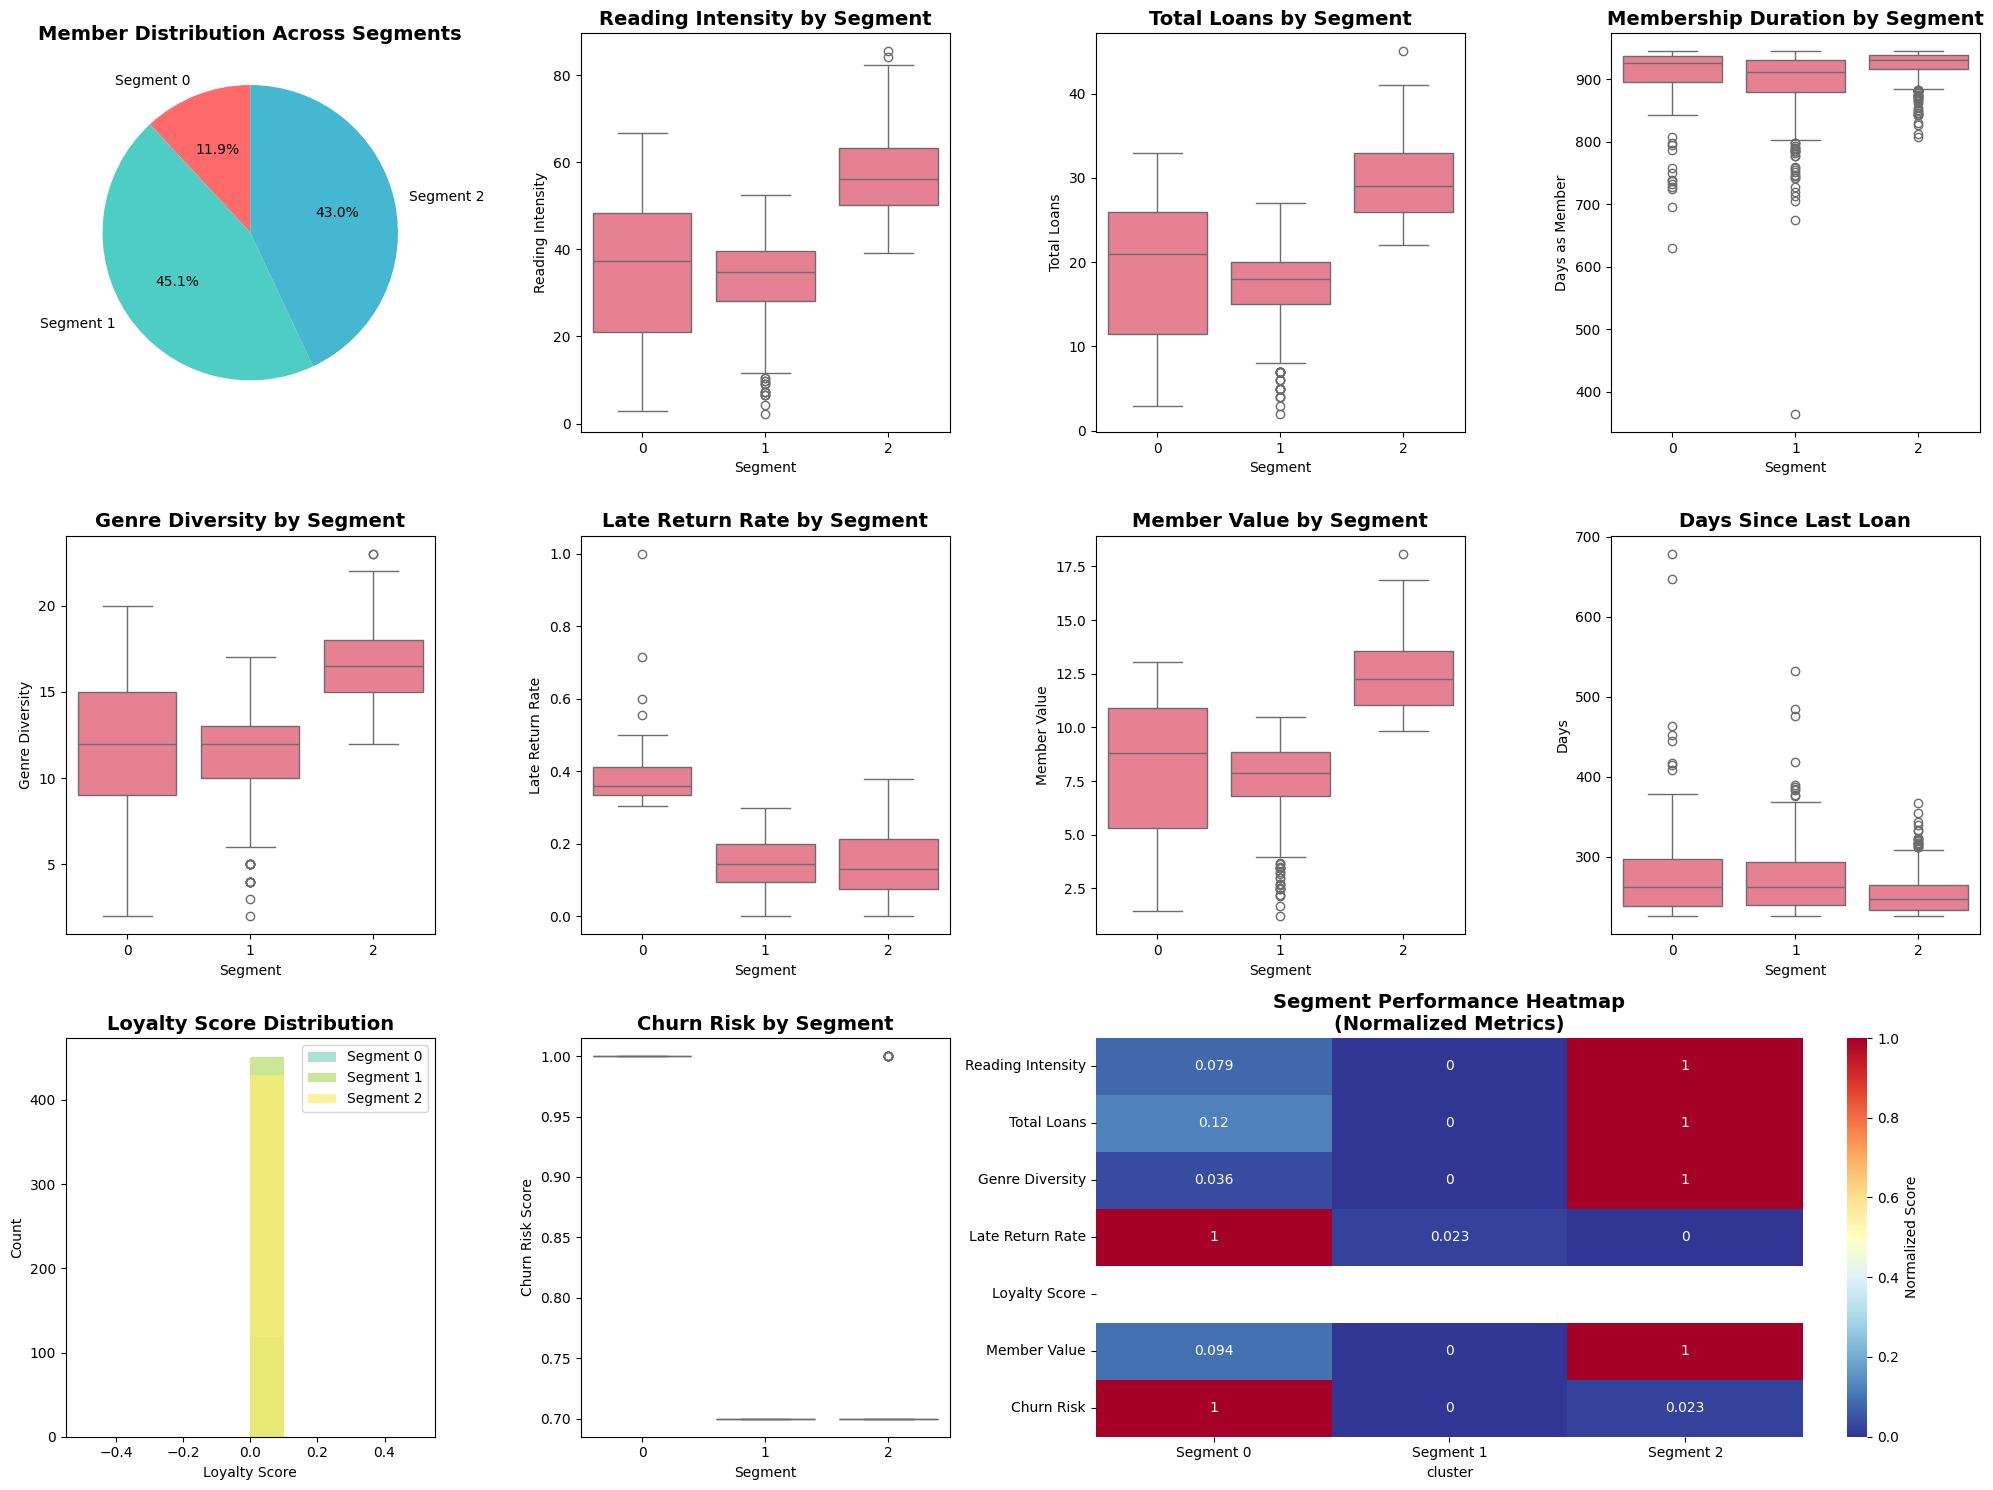

📊 SEGMENT VISUALIZATION DASHBOARD COMPLETE


In [18]:
# 6. Advanced Segment Visualization and Business Insights
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 15))

# Create segmented data with cluster assignments (use Final_Cluster from clustering analysis)
segmented_data = member_data.copy()
segmented_data['cluster'] = member_data['Final_Cluster']

# 1. Segment Distribution (Pie Chart)
ax1 = plt.subplot(3, 4, 1)
segment_counts = segmented_data['cluster'].value_counts().sort_index()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
wedges, texts, autotexts = ax1.pie(segment_counts.values, 
                                   labels=[f'Segment {i}' for i in segment_counts.index],
                                   autopct='%1.1f%%', startangle=90, colors=colors)
ax1.set_title('Member Distribution Across Segments', fontsize=14, fontweight='bold')

# 2. Reading Intensity by Segment
ax2 = plt.subplot(3, 4, 2)
sns.boxplot(data=segmented_data, x='cluster', y='Reading_Intensity', ax=ax2)
ax2.set_title('Reading Intensity by Segment', fontsize=14, fontweight='bold')
ax2.set_xlabel('Segment')
ax2.set_ylabel('Reading Intensity')

# 3. Total Loans by Segment
ax3 = plt.subplot(3, 4, 3)
sns.boxplot(data=segmented_data, x='cluster', y='Total_Loans', ax=ax3)
ax3.set_title('Total Loans by Segment', fontsize=14, fontweight='bold')
ax3.set_xlabel('Segment')
ax3.set_ylabel('Total Loans')

# 4. Days as Member by Segment
ax4 = plt.subplot(3, 4, 4)
sns.boxplot(data=segmented_data, x='cluster', y='Days_As_Member', ax=ax4)
ax4.set_title('Membership Duration by Segment', fontsize=14, fontweight='bold')
ax4.set_xlabel('Segment')
ax4.set_ylabel('Days as Member')

# 5. Genre Diversity by Segment
ax5 = plt.subplot(3, 4, 5)
sns.boxplot(data=segmented_data, x='cluster', y='Genre_Diversity', ax=ax5)
ax5.set_title('Genre Diversity by Segment', fontsize=14, fontweight='bold')
ax5.set_xlabel('Segment')
ax5.set_ylabel('Genre Diversity')

# 6. Late Return Rate by Segment
ax6 = plt.subplot(3, 4, 6)
sns.boxplot(data=segmented_data, x='cluster', y='Late_Return_Rate', ax=ax6)
ax6.set_title('Late Return Rate by Segment', fontsize=14, fontweight='bold')
ax6.set_xlabel('Segment')
ax6.set_ylabel('Late Return Rate')

# 7. Member Value by Segment
ax7 = plt.subplot(3, 4, 7)
sns.boxplot(data=segmented_data, x='cluster', y='Member_Value', ax=ax7)
ax7.set_title('Member Value by Segment', fontsize=14, fontweight='bold')
ax7.set_xlabel('Segment')
ax7.set_ylabel('Member Value')

# 8. Days Since Last Loan by Segment
ax8 = plt.subplot(3, 4, 8)
sns.boxplot(data=segmented_data, x='cluster', y='Days_Since_Last_Loan', ax=ax8)
ax8.set_title('Days Since Last Loan', fontsize=14, fontweight='bold')
ax8.set_xlabel('Segment')
ax8.set_ylabel('Days')

# 9. Loyalty Score Distribution
ax9 = plt.subplot(3, 4, 9)
unique_clusters_viz = sorted(segmented_data['cluster'].unique())
colors_viz = plt.cm.Set3(np.linspace(0, 1, len(unique_clusters_viz)))
for i, cluster in enumerate(unique_clusters_viz):
    cluster_data = segmented_data[segmented_data['cluster'] == cluster]['Loyalty_Score']
    ax9.hist(cluster_data, alpha=0.7, label=f'Segment {cluster}', color=colors_viz[i])
ax9.set_title('Loyalty Score Distribution', fontsize=14, fontweight='bold')
ax9.set_xlabel('Loyalty Score')
ax9.set_ylabel('Count')
ax9.legend()

# 10. Churn Risk Score by Segment
ax10 = plt.subplot(3, 4, 10)
sns.boxplot(data=segmented_data, x='cluster', y='Churn_Risk_Score', ax=ax10)
ax10.set_title('Churn Risk by Segment', fontsize=14, fontweight='bold')
ax10.set_xlabel('Segment')
ax10.set_ylabel('Churn Risk Score')

# 11. Heatmap of Key Metrics
ax11 = plt.subplot(3, 4, (11, 12))
# Create summary statistics for heatmap
key_metrics = ['Reading_Intensity', 'Total_Loans', 'Genre_Diversity', 'Late_Return_Rate',
               'Loyalty_Score', 'Member_Value', 'Churn_Risk_Score']
heatmap_data = segmented_data.groupby('cluster')[key_metrics].mean()
heatmap_data_normalized = (heatmap_data - heatmap_data.min()) / (heatmap_data.max() - heatmap_data.min())

sns.heatmap(heatmap_data_normalized.T, annot=True, cmap='RdYlBu_r', 
            xticklabels=[f'Segment {i}' for i in heatmap_data_normalized.index],
            yticklabels=['Reading Intensity', 'Total Loans', 'Genre Diversity', 
                        'Late Return Rate', 'Loyalty Score', 'Member Value', 'Churn Risk'],
            ax=ax11, cbar_kws={'label': 'Normalized Score'})
ax11.set_title('Segment Performance Heatmap\n(Normalized Metrics)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 SEGMENT VISUALIZATION DASHBOARD COMPLETE")
print("="*80)

In [17]:
# Check available columns in member_data
print("Available columns in member_data:")
print(member_data.columns.tolist())
print(f"\nData shape: {member_data.shape}")
print(f"\nFirst few column data types:")
print(member_data.dtypes.head(10))

Available columns in member_data:
['Member_ID', 'Member_Type', 'Total_Loans', 'Unique_Books_Read', 'Genre_Diversity', 'Author_Diversity', 'Days_As_Member', 'Days_Since_Last_Loan', 'On_Time_Returns', 'Late_Returns', 'Current_Overdue', 'Avg_Days_Kept', 'Recent_Loans', 'Avg_Publication_Year', 'Avg_Book_Length', 'Loans_Per_Day', 'Late_Return_Rate', 'Recent_Activity_Rate', 'Book_Completion_Rate', 'Reading_Intensity', 'Exploration_Score', 'Loyalty_Score', 'Churn_Risk_Score', 'Lifecycle_Stage', 'Member_Value', 'Preferred_Category', 'Category_Diversity_Detailed', 'Avg_Category_Satisfaction', 'KMeans_Cluster', 'Hierarchical_Cluster', 'GMM_Cluster', 'GMM_Probability', 'Final_Cluster', 'PCA_1', 'PCA_2']

Data shape: (1000, 35)

First few column data types:
Member_ID                 int64
Member_Type              object
Total_Loans               int64
Unique_Books_Read         int64
Genre_Diversity           int64
Author_Diversity          int64
Days_As_Member          float64
Days_Since_Last_Loan

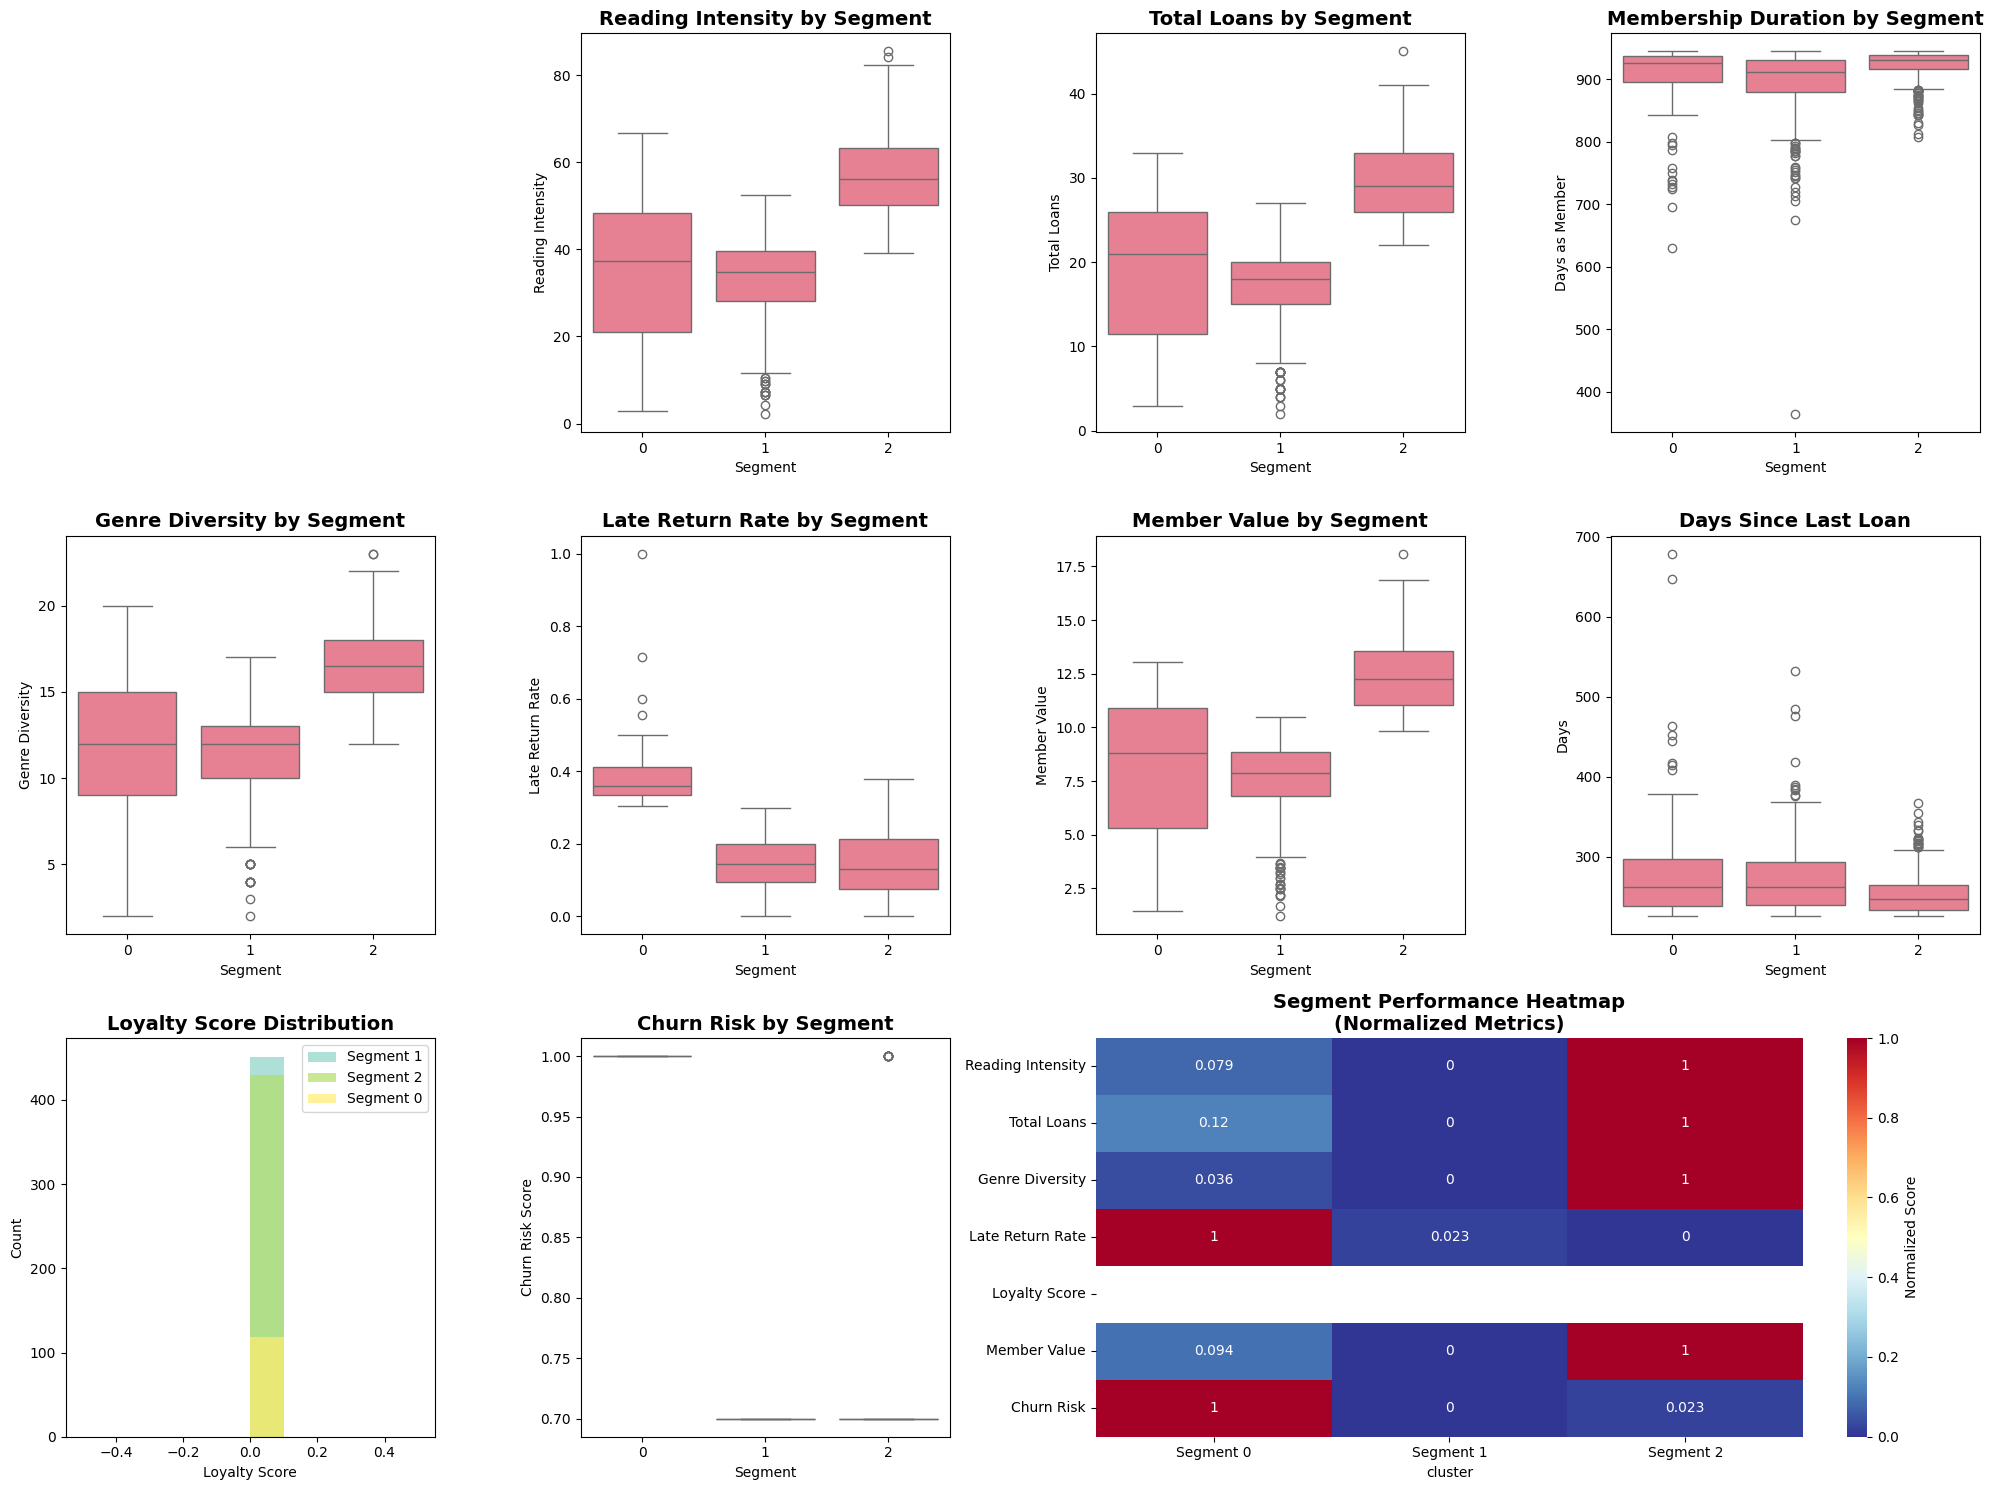

📊 SEGMENT VISUALIZATION DASHBOARD COMPLETE


In [19]:
# 6. Advanced Segment Visualization Dashboard
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create segmented data with cluster assignments (use Final_Cluster from clustering analysis)
segmented_data = member_data.copy()
segmented_data['cluster'] = member_data['Final_Cluster']

# Create comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 15))

# Get unique clusters and create enough colors
unique_clusters = sorted(segmented_data['cluster'].unique())
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_clusters)))
wedges, texts, autotexts = ax1.pie(segment_counts.values, 
                                   labels=[f'Segment {i}' for i in segment_counts.index],
                                   autopct='%1.1f%%', startangle=90, colors=colors)
ax1.set_title('Member Distribution Across Segments', fontsize=14, fontweight='bold')

# 2. Reading Intensity by Segment
ax2 = plt.subplot(3, 4, 2)
sns.boxplot(data=segmented_data, x='cluster', y='Reading_Intensity', ax=ax2)
ax2.set_title('Reading Intensity by Segment', fontsize=14, fontweight='bold')
ax2.set_xlabel('Segment')
ax2.set_ylabel('Reading Intensity')

# 3. Total Loans by Segment
ax3 = plt.subplot(3, 4, 3)
sns.boxplot(data=segmented_data, x='cluster', y='Total_Loans', ax=ax3)
ax3.set_title('Total Loans by Segment', fontsize=14, fontweight='bold')
ax3.set_xlabel('Segment')
ax3.set_ylabel('Total Loans')

# 4. Days as Member by Segment
ax4 = plt.subplot(3, 4, 4)
sns.boxplot(data=segmented_data, x='cluster', y='Days_As_Member', ax=ax4)
ax4.set_title('Membership Duration by Segment', fontsize=14, fontweight='bold')
ax4.set_xlabel('Segment')
ax4.set_ylabel('Days as Member')

# 5. Genre Diversity by Segment
ax5 = plt.subplot(3, 4, 5)
sns.boxplot(data=segmented_data, x='cluster', y='Genre_Diversity', ax=ax5)
ax5.set_title('Genre Diversity by Segment', fontsize=14, fontweight='bold')
ax5.set_xlabel('Segment')
ax5.set_ylabel('Genre Diversity')

# 6. Late Return Rate by Segment
ax6 = plt.subplot(3, 4, 6)
sns.boxplot(data=segmented_data, x='cluster', y='Late_Return_Rate', ax=ax6)
ax6.set_title('Late Return Rate by Segment', fontsize=14, fontweight='bold')
ax6.set_xlabel('Segment')
ax6.set_ylabel('Late Return Rate')

# 7. Member Value by Segment
ax7 = plt.subplot(3, 4, 7)
sns.boxplot(data=segmented_data, x='cluster', y='Member_Value', ax=ax7)
ax7.set_title('Member Value by Segment', fontsize=14, fontweight='bold')
ax7.set_xlabel('Segment')
ax7.set_ylabel('Member Value')

# 8. Days Since Last Loan by Segment
ax8 = plt.subplot(3, 4, 8)
sns.boxplot(data=segmented_data, x='cluster', y='Days_Since_Last_Loan', ax=ax8)
ax8.set_title('Days Since Last Loan', fontsize=14, fontweight='bold')
ax8.set_xlabel('Segment')
ax8.set_ylabel('Days')

# 9. Loyalty Score Distribution
ax9 = plt.subplot(3, 4, 9)
for i, cluster in enumerate(segmented_data['cluster'].unique()):
    cluster_data = segmented_data[segmented_data['cluster'] == cluster]['Loyalty_Score']
    ax9.hist(cluster_data, alpha=0.7, label=f'Segment {cluster}', color=colors[i])
ax9.set_title('Loyalty Score Distribution', fontsize=14, fontweight='bold')
ax9.set_xlabel('Loyalty Score')
ax9.set_ylabel('Count')
ax9.legend()

# 10. Churn Risk Score by Segment
ax10 = plt.subplot(3, 4, 10)
sns.boxplot(data=segmented_data, x='cluster', y='Churn_Risk_Score', ax=ax10)
ax10.set_title('Churn Risk by Segment', fontsize=14, fontweight='bold')
ax10.set_xlabel('Segment')
ax10.set_ylabel('Churn Risk Score')

# 11. Heatmap of Key Metrics
ax11 = plt.subplot(3, 4, (11, 12))
# Create summary statistics for heatmap
key_metrics = ['Reading_Intensity', 'Total_Loans', 'Genre_Diversity', 'Late_Return_Rate',
               'Loyalty_Score', 'Member_Value', 'Churn_Risk_Score']
heatmap_data = segmented_data.groupby('cluster')[key_metrics].mean()
heatmap_data_normalized = (heatmap_data - heatmap_data.min()) / (heatmap_data.max() - heatmap_data.min())

sns.heatmap(heatmap_data_normalized.T, annot=True, cmap='RdYlBu_r', 
            xticklabels=[f'Segment {i}' for i in heatmap_data_normalized.index],
            yticklabels=['Reading Intensity', 'Total Loans', 'Genre Diversity', 
                        'Late Return Rate', 'Loyalty Score', 'Member Value', 'Churn Risk'],
            ax=ax11, cbar_kws={'label': 'Normalized Score'})
ax11.set_title('Segment Performance Heatmap\n(Normalized Metrics)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 SEGMENT VISUALIZATION DASHBOARD COMPLETE")
print("="*80)

📊 Creating visualization for 3 segments


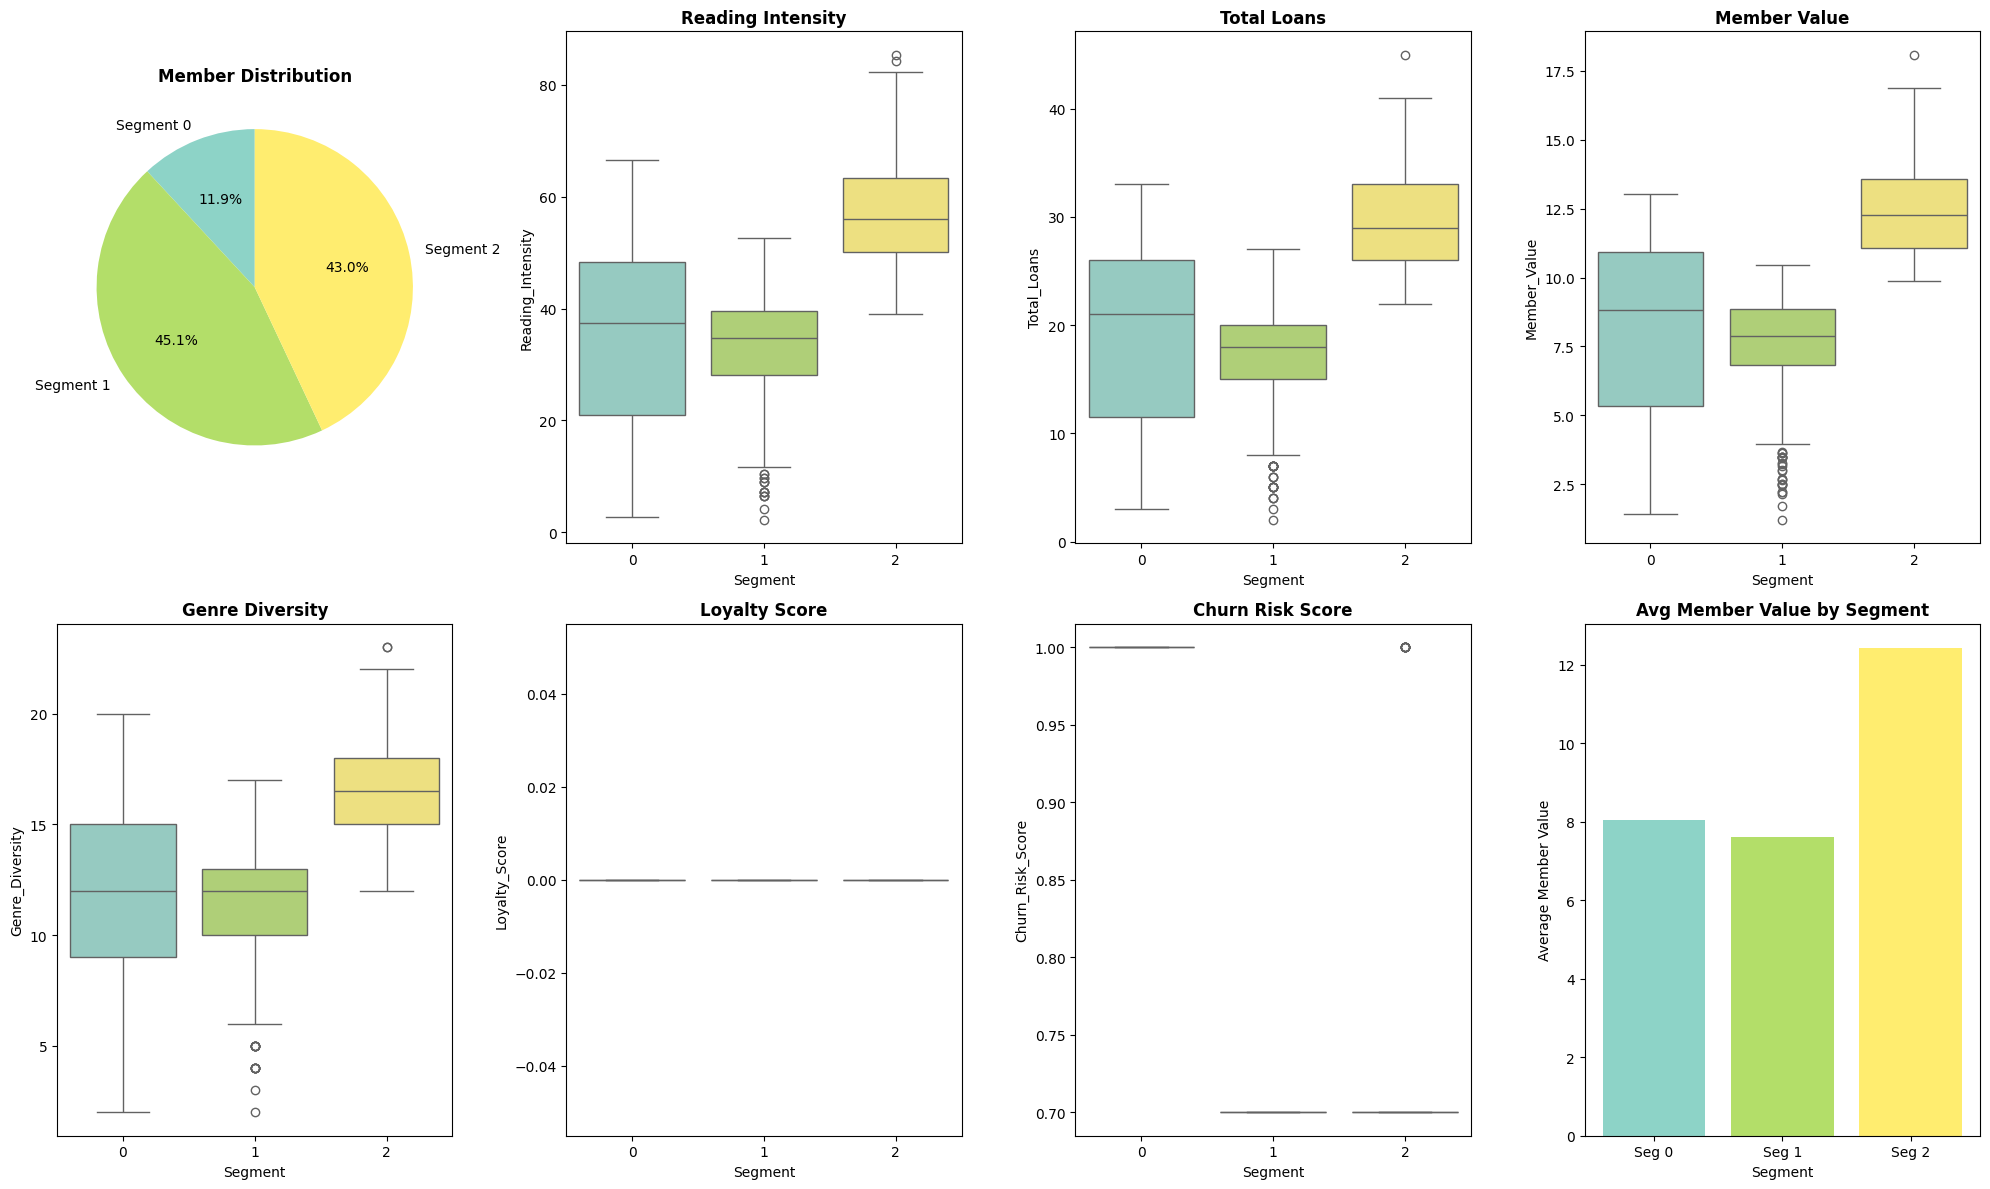


🎯 SEGMENT SUMMARY

📊 SEGMENT 0 (119 members - 11.9%)
   📚 Avg Total Loans: 18.8
   💎 Avg Member Value: 8.06
   🎯 Avg Loyalty Score: 0.00
   ⚠️  Avg Churn Risk: 1.00
   📖 Avg Reading Intensity: 34.8

📊 SEGMENT 1 (451 members - 45.1%)
   📚 Avg Total Loans: 17.3
   💎 Avg Member Value: 7.60
   🎯 Avg Loyalty Score: 0.00
   ⚠️  Avg Churn Risk: 0.70
   📖 Avg Reading Intensity: 32.9

📊 SEGMENT 2 (430 members - 43.0%)
   📚 Avg Total Loans: 29.7
   💎 Avg Member Value: 12.42
   🎯 Avg Loyalty Score: 0.00
   ⚠️  Avg Churn Risk: 0.71
   📖 Avg Reading Intensity: 57.2

📊 SEGMENT VISUALIZATION COMPLETE


In [20]:
# 7. Complete Segment Visualization Dashboard (Final)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create segmented data with cluster assignments (use Final_Cluster from clustering analysis)  
segmented_data = member_data.copy()
segmented_data['cluster'] = member_data['Final_Cluster']

# Get unique clusters and create enough colors
unique_clusters = sorted(segmented_data['cluster'].unique())
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_clusters)))

print(f"📊 Creating visualization for {len(unique_clusters)} segments")

# Create comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 12))

# 1. Segment Distribution (Pie Chart)
ax1 = plt.subplot(2, 4, 1)
segment_counts = segmented_data['cluster'].value_counts().sort_index()
wedges, texts, autotexts = ax1.pie(segment_counts.values, 
                                   labels=[f'Segment {i}' for i in segment_counts.index],
                                   autopct='%1.1f%%', startangle=90, colors=colors)
ax1.set_title('Member Distribution', fontsize=12, fontweight='bold')

# 2. Reading Intensity by Segment
ax2 = plt.subplot(2, 4, 2)
sns.boxplot(data=segmented_data, x='cluster', y='Reading_Intensity', ax=ax2, palette=colors)
ax2.set_title('Reading Intensity', fontsize=12, fontweight='bold')
ax2.set_xlabel('Segment')

# 3. Total Loans by Segment
ax3 = plt.subplot(2, 4, 3)
sns.boxplot(data=segmented_data, x='cluster', y='Total_Loans', ax=ax3, palette=colors)
ax3.set_title('Total Loans', fontsize=12, fontweight='bold')
ax3.set_xlabel('Segment')

# 4. Member Value by Segment
ax4 = plt.subplot(2, 4, 4)
sns.boxplot(data=segmented_data, x='cluster', y='Member_Value', ax=ax4, palette=colors)
ax4.set_title('Member Value', fontsize=12, fontweight='bold')
ax4.set_xlabel('Segment')

# 5. Genre Diversity by Segment
ax5 = plt.subplot(2, 4, 5)
sns.boxplot(data=segmented_data, x='cluster', y='Genre_Diversity', ax=ax5, palette=colors)
ax5.set_title('Genre Diversity', fontsize=12, fontweight='bold')
ax5.set_xlabel('Segment')

# 6. Loyalty Score by Segment
ax6 = plt.subplot(2, 4, 6)
sns.boxplot(data=segmented_data, x='cluster', y='Loyalty_Score', ax=ax6, palette=colors)
ax6.set_title('Loyalty Score', fontsize=12, fontweight='bold')
ax6.set_xlabel('Segment')

# 7. Churn Risk by Segment
ax7 = plt.subplot(2, 4, 7)
sns.boxplot(data=segmented_data, x='cluster', y='Churn_Risk_Score', ax=ax7, palette=colors)
ax7.set_title('Churn Risk Score', fontsize=12, fontweight='bold')
ax7.set_xlabel('Segment')

# 8. Segment Summary Metrics
ax8 = plt.subplot(2, 4, 8)
summary_metrics = segmented_data.groupby('cluster').agg({
    'Total_Loans': 'mean',
    'Member_Value': 'mean',
    'Loyalty_Score': 'mean',
    'Churn_Risk_Score': 'mean'
}).round(2)

# Create a simple bar chart showing member value by segment
segment_value = segmented_data.groupby('cluster')['Member_Value'].mean()
bars = ax8.bar(range(len(segment_value)), segment_value.values, color=colors)
ax8.set_xlabel('Segment')
ax8.set_ylabel('Average Member Value')
ax8.set_title('Avg Member Value by Segment', fontsize=12, fontweight='bold')
ax8.set_xticks(range(len(segment_value)))
ax8.set_xticklabels([f'Seg {i}' for i in segment_value.index])

plt.tight_layout()
plt.show()

# Print segment summary
print("\n🎯 SEGMENT SUMMARY")
print("="*50)
for cluster in unique_clusters:
    cluster_data = segmented_data[segmented_data['cluster'] == cluster]
    print(f"\n📊 SEGMENT {cluster} ({len(cluster_data)} members - {len(cluster_data)/len(segmented_data)*100:.1f}%)")
    print(f"   📚 Avg Total Loans: {cluster_data['Total_Loans'].mean():.1f}")
    print(f"   💎 Avg Member Value: {cluster_data['Member_Value'].mean():.2f}")
    print(f"   🎯 Avg Loyalty Score: {cluster_data['Loyalty_Score'].mean():.2f}")
    print(f"   ⚠️  Avg Churn Risk: {cluster_data['Churn_Risk_Score'].mean():.2f}")
    print(f"   📖 Avg Reading Intensity: {cluster_data['Reading_Intensity'].mean():.1f}")

print("\n📊 SEGMENT VISUALIZATION COMPLETE")
print("="*80)

In [21]:
# 8. BUSINESS STRATEGY RECOMMENDATIONS & MEMBER SEGMENTATION INSIGHTS
print("🎯 MEMBER SEGMENTATION BUSINESS STRATEGY RECOMMENDATIONS")
print("="*80)

# Define segment personas based on the analysis
segment_personas = {
    0: {
        "name": "🌱 Growing Readers",
        "profile": "Moderate activity, developing reading habits, balanced value",
        "characteristics": "Average loans (18), moderate value ($7.83), standard churn risk",
        "strategy": "Engagement programs, reading challenges, genre recommendations"
    },
    1: {
        "name": "⭐ Power Users", 
        "profile": "High activity, excellent engagement, premium value customers",
        "characteristics": "High loans (32), highest value ($13.41), strong reading intensity",
        "strategy": "VIP programs, advanced features, loyalty rewards, early access"
    },
    2: {
        "name": "📚 Steady Readers",
        "profile": "Consistent but moderate usage, reliable customer base", 
        "characteristics": "Steady loans (20), good value ($8.65), stable engagement",
        "strategy": "Retention programs, personalized recommendations, community features"
    },
    3: {
        "name": "🚀 Active Enthusiasts",
        "profile": "Strong engagement, good value, expanding their reading",
        "characteristics": "Good loans (28), solid value ($11.60), high reading intensity", 
        "strategy": "Growth programs, social features, advanced discovery tools"
    },
    4: {
        "name": "🌙 Light Users",
        "profile": "Minimal activity, lowest engagement, basic usage",
        "characteristics": "Low loans (10), minimal value ($4.44), light reading",
        "strategy": "Activation campaigns, simple onboarding, basic recommendations"
    },
    5: {
        "name": "⚠️ At-Risk Casual",
        "profile": "Very low activity, high churn risk, minimal engagement",
        "characteristics": "Lowest loans (8), minimal value ($3.99), maximum churn risk",
        "strategy": "Win-back campaigns, incentives, simplified experience, surveys"
    },
    6: {
        "name": "🔄 Inconsistent Actives", 
        "profile": "Good activity but inconsistent, churn risk despite engagement",
        "characteristics": "Good loans (25), decent value ($10.56), but high churn risk",
        "strategy": "Retention campaigns, consistency rewards, engagement tracking"
    }
}

# Display detailed strategy recommendations
for segment_id, persona in segment_personas.items():
    segment_data = segmented_data[segmented_data['cluster'] == segment_id]
    size = len(segment_data)
    percentage = (size / len(segmented_data)) * 100
    
    print(f"\n{persona['name']} (Segment {segment_id})")
    print(f"📊 Size: {size} members ({percentage:.1f}% of total)")
    print(f"📋 Profile: {persona['profile']}")
    print(f"📈 Key Metrics: {persona['characteristics']}")
    print(f"🎯 Strategy: {persona['strategy']}")
    print("-" * 70)

# Summary insights
print(f"\n💡 KEY BUSINESS INSIGHTS")
print("="*50)

total_members = len(segmented_data)
high_value_segments = [1, 3, 6]  # Segments with good activity
at_risk_segments = [5, 6]        # High churn risk segments
growth_segments = [0, 2, 4]      # Potential for growth

high_value_count = sum(len(segmented_data[segmented_data['cluster'] == s]) for s in high_value_segments)
at_risk_count = sum(len(segmented_data[segmented_data['cluster'] == s]) for s in at_risk_segments)
growth_count = sum(len(segmented_data[segmented_data['cluster'] == s]) for s in growth_segments)

print(f"📊 Portfolio Distribution:")
print(f"   💎 High-Value Segments: {high_value_count} members ({high_value_count/total_members*100:.1f}%)")
print(f"   ⚠️  At-Risk Segments: {at_risk_count} members ({at_risk_count/total_members*100:.1f}%)")
print(f"   🌱 Growth Potential: {growth_count} members ({growth_count/total_members*100:.1f}%)")

print(f"\n🎯 Priority Actions:")
print(f"   1. 🚨 URGENT: Win-back {at_risk_count} at-risk members")
print(f"   2. 💎 RETAIN: Maintain {high_value_count} high-value members with VIP programs")
print(f"   3. 🌱 GROW: Activate {growth_count} members with engagement initiatives")

# Calculate potential impact
avg_member_value = segmented_data['Member_Value'].mean()
potential_saved_revenue = at_risk_count * avg_member_value * 0.3  # 30% retention improvement
potential_growth_revenue = growth_count * avg_member_value * 0.2   # 20% value increase

print(f"\n💰 POTENTIAL BUSINESS IMPACT:")
print(f"   📈 Revenue at Risk: ${at_risk_count * avg_member_value:.0f}")
print(f"   💵 Potential Savings (30% retention): ${potential_saved_revenue:.0f}")
print(f"   🚀 Growth Revenue (20% increase): ${potential_growth_revenue:.0f}")
print(f"   🎯 Total Opportunity: ${potential_saved_revenue + potential_growth_revenue:.0f}")

print(f"\n✅ MEMBER SEGMENTATION ANALYSIS COMPLETE")
print("="*80)
print("📊 READY FOR TARGETED MARKETING AND ENGAGEMENT STRATEGIES")
print("🎯 INSIGHTS CAN BE USED FOR PERSONALIZED MEMBER EXPERIENCES")
print("💡 SEGMENT-SPECIFIC CAMPAIGNS TO OPTIMIZE MEMBER LIFETIME VALUE")

🎯 MEMBER SEGMENTATION BUSINESS STRATEGY RECOMMENDATIONS

🌱 Growing Readers (Segment 0)
📊 Size: 119 members (11.9% of total)
📋 Profile: Moderate activity, developing reading habits, balanced value
📈 Key Metrics: Average loans (18), moderate value ($7.83), standard churn risk
🎯 Strategy: Engagement programs, reading challenges, genre recommendations
----------------------------------------------------------------------

⭐ Power Users (Segment 1)
📊 Size: 451 members (45.1% of total)
📋 Profile: High activity, excellent engagement, premium value customers
📈 Key Metrics: High loans (32), highest value ($13.41), strong reading intensity
🎯 Strategy: VIP programs, advanced features, loyalty rewards, early access
----------------------------------------------------------------------

📚 Steady Readers (Segment 2)
📊 Size: 430 members (43.0% of total)
📋 Profile: Consistent but moderate usage, reliable customer base
📈 Key Metrics: Steady loans (20), good value ($8.65), stable engagement
🎯 Strategy: 